# Project overview and how to run

This notebook builds an NFL game result predictor using 2023–2025 data.
- Loads 2023/2024 scores (and optional play-by-play) and engineers leak-free features (Elo, recent form, H2H, optional offense/defense).
- Trains Logistic Regression and RandomForest models.
- Evaluates on 2024 and 2025 Weeks 1–2; saves models for reuse.
- Paths are relative to the repository root; place CSVs alongside the notebook.

Run top-to-bottom after installing requirements (see README).


In [49]:
# Setup: versions and reproducibility
import sys, platform, random
import numpy as np
import pandas as pd
import sklearn
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print({'python': sys.version.split()[0], 'platform': platform.platform(), 'numpy': np.__version__, 'pandas': pd.__version__, 'sklearn': sklearn.__version__})


{'python': '3.13.5', 'platform': 'macOS-15.6.1-arm64-arm-64bit-Mach-O', 'numpy': '2.3.3', 'pandas': '2.3.2', 'sklearn': '1.7.2'}


# NFL Game Result Predictor

This notebook builds a simple baseline model to predict NFL game outcomes using 2023 and 2024 regular season scores.

Outline:
- Load and combine CSVs
- Feature engineering (rolling stats, Elo)
- Train/test split by time
- Baseline logistic regression and evaluation
- Save model and quick inference helper


In [ ]:
"""
This cell was for cleaning data, but I only have the clean data uploaded so this code is not necessary

Clean FootballDB-like 2023 NFL games sheet into:
Week, Date, Visitor, VisitorScore, Home, HomeScore, OT
"""

INPUT_PATH = "2025 nfl scores - Sheet1.csv"        # change if needed
OUTPUT_PATH = "nfl_scores_2025_clean.csv"

def looks_like_date(s: str) -> bool:
    return bool(re.match(r'^\s*\d{2}/\d{2}/\d{4}\s*$', str(s)))

# Load raw (sheet has 6 columns: first col carries Week/Date/labels)
raw = pd.read_csv(INPUT_PATH)

col_date   = raw.columns[0]  # shows "Week X" labels, then "Date", then mm/dd/yyyy values
col_vis    = raw.columns[1]  # Visitor team or the word "Visitor"
col_vscore = raw.columns[2]  # Visitor score
col_home   = raw.columns[3]  # Home team or the word "Home"
col_hscore = raw.columns[4]  # Home score
col_ot     = raw.columns[5]  # "OT" sometimes

records = []
current_week = None
ROUND_LABELS = {"Wild Card Playoff", "Divisional Playoff", "Conference Championship", "Super Bowl"}

for _, row in raw.iterrows():
    c0, c1, c2, c3, c4, c5 = row[col_date], row[col_vis], row[col_vscore], row[col_home], row[col_hscore], row[col_ot]

    # Update Week / Round when we hit a header row in col 0
    if isinstance(c0, str):
        s0 = c0.strip()
        if re.match(r'^Week\s+\d+$', s0, flags=re.IGNORECASE):
            current_week = s0
            continue
        if s0 in ROUND_LABELS:
            current_week = s0
            continue
        # skip header line like: "Date | Visitor | Home"
        if s0.lower() == "date" and isinstance(c1, str) and c1.strip().lower() == "visitor":
            continue

    # Only parse game rows that begin with a real date
    if not looks_like_date(c0):
        continue

    # Extract fields (skip incomplete rows)
    date_str = str(c0).strip()
    visitor  = str(c1).strip() if isinstance(c1, str) and c1 and str(c1).strip() else None
    home     = str(c3).strip() if isinstance(c3, str) and c3 and str(c3).strip() else None
    if not visitor or not home:
        continue

    # Scores
    try:
        vscore = int(float(c2)) if pd.notna(c2) else None
    except Exception:
        vscore = None
    try:
        hscore = int(float(c4)) if pd.notna(c4) else None
    except Exception:
        hscore = None

    ot_flag = "OT" if isinstance(c5, str) and "OT" in c5.upper() else ""

    records.append({
        "Week": current_week or "",
        "Date": pd.to_datetime(date_str, format="%m/%d/%Y").date().isoformat(),
        "Visitor": visitor,
        "VisitorScore": vscore,
        "Home": home,
        "HomeScore": hscore,
        "OT": ot_flag
    })

clean = pd.DataFrame.from_records(records, columns=["Week","Date","Visitor","VisitorScore","Home","HomeScore","OT"])
clean.to_csv(OUTPUT_PATH, index=False)

print(f"Saved {len(clean)} games to {OUTPUT_PATH}")


Saved 272 games to nfl_scores_2025_clean.csv


In [51]:
from __future__ import annotations
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('/Users/adrianahmetspahic/Desktop/Berkeley Code and Data')
CSV_2023 = DATA_DIR / 'Cleaned_NFL_2023_Scores.csv'
CSV_2024 = DATA_DIR / 'nfl_scores_2024_clean.csv'

# Load CSVs
scores_2023 = pd.read_csv(CSV_2023)
scores_2024 = pd.read_csv(CSV_2024)

for df in (scores_2023, scores_2024):
    assert set(['Week','Date','Visitor','VisitorScore','Home','HomeScore']).issubset(df.columns), 'Unexpected schema'

# Normalize date/week types
for df in (scores_2023, scores_2024):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Season'] = df['Date'].dt.year
    # Convert like 'Week 1' -> 1 (nullable int, robust to missing)
    week_num = df['Week'].astype(str).str.extract(r'(\d+)')[0]
    df['WeekNum'] = pd.to_numeric(week_num, errors='coerce').astype('Int64')

scores = (
    pd.concat([scores_2023, scores_2024], ignore_index=True)
      .sort_values(['Date', 'Home', 'Visitor'])
      .reset_index(drop=True)
)

# Derive target: 1 if home team won
scores['HomeWin'] = (scores['HomeScore'] > scores['VisitorScore']).astype(int)

print(scores.head())
print(scores[['Season','Week','Date']].tail(3))
print('Total games:', len(scores))


     Week       Date             Visitor  VisitorScore                Home  \
0  Week 1 2023-09-07       Detroit Lions            21  Kansas City Chiefs   
1  Week 1 2023-09-10   Carolina Panthers            10     Atlanta Falcons   
2  Week 1 2023-09-10      Houston Texans             9    Baltimore Ravens   
3  Week 1 2023-09-10   Green Bay Packers            38       Chicago Bears   
4  Week 1 2023-09-10  Cincinnati Bengals             3    Cleveland Browns   

   HomeScore   OT  Season  WeekNum  HomeWin  
0         20  NaN    2023        1        0  
1         24  NaN    2023        1        1  
2         25  NaN    2023        1        1  
3         20  NaN    2023        1        0  
4         24  NaN    2023        1        1  
     Season                     Week       Date
567    2025  Conference Championship 2025-01-26
568    2025  Conference Championship 2025-01-26
569    2025               Super Bowl 2025-02-09
Total games: 570


In [52]:
# Feature engineering: simple Elo + recent form (no leakage)

def initialize_elo(teams, base=1500.0):
    return {team: base for team in teams}

K = 20.0
HOME_FIELD = 55.0

teams = pd.unique(pd.concat([scores['Home'], scores['Visitor']]))
elo = initialize_elo(teams)

rows = []
for _, g in scores.sort_values('Date').iterrows():
    home = g['Home']
    away = g['Visitor']
    home_elo = elo[home]
    away_elo = elo[away]
    # Pre-game features
    rows.append({
        'Date': g['Date'],
        'Season': g['Season'],
        'WeekNum': g['WeekNum'],
        'Home': home,
        'Visitor': away,
        'HomeScore': g['HomeScore'],
        'VisitorScore': g['VisitorScore'],
        'HomeWin': g['HomeWin'],
        'home_elo_pre': home_elo,
        'away_elo_pre': away_elo,
        'elo_diff_pre': (home_elo + HOME_FIELD) - away_elo,
    })

    # Post-game Elo update
    home_margin = g['HomeScore'] - g['VisitorScore']
    if pd.isna(home_margin):
        continue
    expected_home = 1.0 / (1.0 + 10 ** (-(home_elo + HOME_FIELD - away_elo)/400.0))
    actual_home = 1.0 if home_margin > 0 else (0.5 if home_margin == 0 else 0.0)
    delta = K * (actual_home - expected_home)
    elo[home] = home_elo + delta
    elo[away] = away_elo - delta

elo_df = pd.DataFrame(rows)

# Recent form: rolling averages of points for/against in previous 3 games
# Build team-game rows to safely compute lagged rolling stats
home_rows = elo_df[['Date','Season','WeekNum','Home','HomeScore','VisitorScore']].copy()
home_rows = home_rows.rename(columns={'Home':'Team','HomeScore':'PointsFor','VisitorScore':'PointsAgainst'})
away_rows = elo_df[['Date','Season','WeekNum','Visitor','HomeScore','VisitorScore']].copy()
away_rows = away_rows.rename(columns={'Visitor':'Team','VisitorScore':'PointsFor','HomeScore':'PointsAgainst'})
team_games = pd.concat([home_rows, away_rows], ignore_index=True)
team_games = team_games.sort_values(['Team','Date']).reset_index(drop=True)

team_games['pf_roll3'] = team_games.groupby('Team')['PointsFor'].shift(1).rolling(3, min_periods=1).mean()
team_games['pa_roll3'] = team_games.groupby('Team')['PointsAgainst'].shift(1).rolling(3, min_periods=1).mean()

# Merge back to games
home_feats = team_games[['Date','Team','pf_roll3','pa_roll3']].rename(columns={'Team':'Home','pf_roll3':'home_pf3','pa_roll3':'home_pa3'})
away_feats = team_games[['Date','Team','pf_roll3','pa_roll3']].rename(columns={'Team':'Visitor','pf_roll3':'away_pf3','pa_roll3':'away_pa3'})

feat_df = (elo_df
    .merge(home_feats, on=['Date','Home'], how='left')
    .merge(away_feats, on=['Date','Visitor'], how='left')
)

# Differences as model inputs
feat_df['elo_diff_pre'] = feat_df['elo_diff_pre']
feat_df['pf3_diff'] = feat_df['home_pf3'] - feat_df['away_pf3']
feat_df['pa3_diff'] = feat_df['home_pa3'] - feat_df['away_pa3']

feat_cols = ['elo_diff_pre','pf3_diff','pa3_diff']
print(feat_df[feat_cols + ['HomeWin']].describe(include='all'))


       elo_diff_pre    pf3_diff    pa3_diff     HomeWin
count    570.000000  569.000000  569.000000  570.000000
mean      57.263563   -0.118043   -0.012009    0.556140
std       64.323713    9.296224    8.423828    0.497275
min     -192.449585  -24.666667  -33.000000    0.000000
25%       19.061242   -7.000000   -5.333333    0.000000
50%       55.000000   -0.333333    0.333333    1.000000
75%       92.585391    6.000000    5.666667    1.000000
max      280.766858   28.000000   21.666667    1.000000


In [53]:
# Train/test split by date (no leakage)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, log_loss, confusion_matrix

X = feat_df[feat_cols].fillna(0.0)
y = feat_df['HomeWin']

# Time-based split: use 2023 as train, 2024 as test by default
train_mask = feat_df['Season'] <= 2023
test_mask = feat_df['Season'] == 2024

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, pred))
print('ROC AUC:', roc_auc_score(y_test, proba))
print('Brier:', brier_score_loss(y_test, proba))
print('LogLoss:', log_loss(y_test, proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, pred))


Accuracy: 0.6842105263157895
ROC AUC: 0.735838779956427
Brier: 0.21448898190668855
LogLoss: 0.6183441844158715
Confusion Matrix:
 [[ 69  63]
 [ 27 126]]


In [54]:
# Simple prediction helper for a given matchup

def predict_home_win_probability(model, home_team: str, away_team: str, as_of_date=None):
    # Use latest known features (pre-game Elo, rolling PF/PA) from feat_df
    df = feat_df.sort_values('Date')
    latest_home = df[df['Home'] == home_team].tail(1)
    latest_away = df[df['Visitor'] == away_team].tail(1)
    if latest_home.empty or latest_away.empty:
        raise ValueError('Insufficient history for one of the teams to estimate features.')
    # Approximate by taking most recent row involving the team
    # Use elo_diff_pre relative to these two teams is tricky; fall back to team-specific features
    # We will compute a proxy: use last known home_elo_pre/away_elo_pre from this pairing if exists
    last_meeting = df[(df['Home'] == home_team) & (df['Visitor'] == away_team)].tail(1)
    if not last_meeting.empty:
        elo_diff = float(last_meeting['elo_diff_pre'].iloc[0])
    else:
        # fallback: difference of each team's last known base elos against any opponent
        last_home_any = df[(df['Home'] == home_team) | (df['Visitor'] == home_team)].tail(1)
        last_away_any = df[(df['Home'] == away_team) | (df['Visitor'] == away_team)].tail(1)
        # infer team elo from columns
        def infer_team_elo(row, team):
            if row['Home'] == team:
                return float(row['home_elo_pre'])
            else:
                return float(row['away_elo_pre'])
        if not last_home_any.empty and not last_away_any.empty:
            elo_diff = infer_team_elo(last_home_any.iloc[0], home_team) + HOME_FIELD - infer_team_elo(last_away_any.iloc[0], away_team)
        else:
            elo_diff = 0.0

    # rolling diffs: use last known PF/PA rolling stats
    def last_roll(df_team, name_home, name_away, team, col):
        last_any = df_team[(df_team['Home'] == team) | (df_team['Visitor'] == team)].tail(1)
        if last_any.empty:
            return np.nan
        if last_any.iloc[0]['Home'] == team:
            return float(last_any.iloc[0][name_home])
        return float(last_any.iloc[0][name_away])

    home_pf3 = last_roll(df, 'home_pf3', 'away_pf3', home_team, 'pf3')
    away_pf3 = last_roll(df, 'home_pf3', 'away_pf3', away_team, 'pf3')
    home_pa3 = last_roll(df, 'home_pa3', 'away_pa3', home_team, 'pa3')
    away_pa3 = last_roll(df, 'home_pa3', 'away_pa3', away_team, 'pa3')

    X_row = pd.DataFrame([{
        'elo_diff_pre': elo_diff,
        'pf3_diff': home_pf3 - away_pf3 if pd.notna(home_pf3) and pd.notna(away_pf3) else 0.0,
        'pa3_diff': home_pa3 - away_pa3 if pd.notna(home_pa3) and pd.notna(away_pa3) else 0.0,
    }])
    proba = float(model.predict_proba(X_row)[:,1][0])
    return proba

# Example usage (edit teams as desired):
# predict_home_win_probability(pipe, 'San Francisco 49ers', 'Dallas Cowboys')


In [55]:
# Example predictions for selected matchups
matchups = [
    ('Kansas City Chiefs', 'Baltimore Ravens'),
    ('San Francisco 49ers', 'Dallas Cowboys'),
    ('Philadelphia Eagles', 'Green Bay Packers'),
    ('Buffalo Bills', 'Miami Dolphins'),
]

for home, away in matchups:
    try:
        p = predict_home_win_probability(pipe, home, away)
        print(f"{home} vs {away}: P(home win) = {p:.3f}")
    except Exception as e:
        print(f"{home} vs {away}: could not compute ({e})")


Kansas City Chiefs vs Baltimore Ravens: P(home win) = 0.489
San Francisco 49ers vs Dallas Cowboys: P(home win) = 0.550
Philadelphia Eagles vs Green Bay Packers: P(home win) = 0.663
Buffalo Bills vs Miami Dolphins: P(home win) = 0.687


In [56]:
# Predicted probabilities on 2024 holdout games
from IPython.display import display
subset = feat_df[feat_df['Season'] == 2024].copy()
subset = subset.assign(pred_proba=pipe.predict_proba(subset[feat_cols].fillna(0.0))[:,1])

display(subset[['Date','Home','Visitor','pred_proba','HomeWin']].sort_values('Date').head(20))
print('\nSample of predicted 2024 games with true result (HomeWin).')


,Date,Home,Visitor,pred_proba,HomeWin
256,2024-01-06,Baltimore Ravens,Pittsburgh Steelers,0.715881,0
257,2024-01-06,Indianapolis Colts,Houston Texans,0.557745,0
271,2024-01-07,Los Angeles Chargers,Kansas City Chiefs,0.421184,0
270,2024-01-07,Arizona Cardinals,Seattle Seahawks,0.505219,0
269,2024-01-07,Carolina Panthers,Tampa Bay Buccaneers,0.370254,0
268,2024-01-07,Cincinnati Bengals,Cleveland Browns,0.430701,1
267,2024-01-07,Detroit Lions,Minnesota Vikings,0.704703,1
266,2024-01-07,Green Bay Packers,Chicago Bears,0.583689,1
265,2024-01-07,Las Vegas Raiders,Denver Broncos,0.617780,1
263,2024-01-07,New England Patriots,New York Jets,0.555282,0



Sample of predicted 2024 games with true result (HomeWin).


In [57]:
# Extended features: offensive/defensive (yards/play, yards, TDs), win rates, H2H
from collections import defaultdict

TEAM_ABBR_TO_NAME = {
    'ARI':'Arizona Cardinals','ATL':'Atlanta Falcons','BAL':'Baltimore Ravens','BUF':'Buffalo Bills',
    'CAR':'Carolina Panthers','CHI':'Chicago Bears','CIN':'Cincinnati Bengals','CLE':'Cleveland Browns',
    'DAL':'Dallas Cowboys','DEN':'Denver Broncos','DET':'Detroit Lions','GB':'Green Bay Packers',
    'HOU':'Houston Texans','IND':'Indianapolis Colts','JAX':'Jacksonville Jaguars','KC':'Kansas City Chiefs',
    'LAC':'Los Angeles Chargers','LAR':'Los Angeles Rams','LV':'Las Vegas Raiders','MIA':'Miami Dolphins',
    'MIN':'Minnesota Vikings','NE':'New England Patriots','NO':'New Orleans Saints','NYG':'New York Giants',
    'NYJ':'New York Jets','PHI':'Philadelphia Eagles','PIT':'Pittsburgh Steelers','SEA':'Seattle Seahawks',
    'SF':'San Francisco 49ers','TB':'Tampa Bay Buccaneers','TEN':'Tennessee Titans','WAS':'Washington Commanders'
}
TEAM_NAME_TO_ABBR = {v:k for k,v in TEAM_ABBR_TO_NAME.items()}

PBP_FILES = [DATA_DIR / 'pbp-2023.csv', DATA_DIR / 'pbp-2024.csv']

# Helper to safely read PBP columns present
wanted_cols = ['game_id','season','week','posteam','defteam','yards_gained','epa','touchdown','play_type','home_team','away_team']
pbp_frames = []
for f in PBP_FILES:
    if not f.exists():
        continue
    sample = pd.read_csv(f, nrows=5)
    cols = [c for c in wanted_cols if c in sample.columns]
    df_p = pd.read_csv(f, usecols=cols, low_memory=False)
    # standardize types
    if 'season' in df_p.columns:
        df_p['season'] = pd.to_numeric(df_p['season'], errors='coerce').astype('Int64')
    if 'week' in df_p.columns:
        df_p['week'] = pd.to_numeric(df_p['week'], errors='coerce').astype('Int64')
    pbp_frames.append(df_p)

if len(pbp_frames):
    pbp = pd.concat(pbp_frames, ignore_index=True)
    # Valid offensive plays: prefer run/pass if available, else any row with yards_gained
    has_play_type = 'play_type' in pbp.columns
    has_yards = 'yards_gained' in pbp.columns
    valid_yards = pd.to_numeric(pbp['yards_gained'], errors='coerce').notna() if has_yards else pd.Series(False, index=pbp.index)
    valid_play = pbp['play_type'].isin(['run','pass']) if has_play_type else valid_yards

    has_posteam = 'posteam' in pbp.columns
    has_defteam = 'defteam' in pbp.columns
    posteam_notna = pbp['posteam'].notna() if has_posteam else pd.Series(False, index=pbp.index)
    defteam_notna = pbp['defteam'].notna() if has_defteam else pd.Series(False, index=pbp.index)

    mask_off = valid_yards & valid_play & posteam_notna
    mask_def = valid_yards & valid_play & defteam_notna

    # Prepare touchdown and epa safely
    td_col = 'touchdown' if 'touchdown' in pbp.columns else None
    epa_col = 'epa' if 'epa' in pbp.columns else None

    def safe_sum(series):
        if series is None:
            return 0.0
        s = pd.to_numeric(series, errors='coerce').fillna(0)
        return s.sum()

    # Offensive per-game aggregation (robust to missing columns)
    off_df = pbp.loc[mask_off].copy()
    keys_off = ['season','week','posteam']
    pieces = []
    # plays count
    if len(off_df):
        plays = off_df.groupby(keys_off).size().rename('off_plays').reset_index()
        pieces.append(plays)
    # yards_gained stats if available
    if 'yards_gained' in off_df.columns:
        off_df['yards_gained'] = pd.to_numeric(off_df['yards_gained'], errors='coerce')
        yards = off_df.groupby(keys_off)['yards_gained'].agg(off_total_yards='sum', off_ypp='mean').reset_index()
        pieces.append(yards)
    # touchdowns if available
    if td_col and td_col in off_df.columns:
        tds = off_df.groupby(keys_off)[td_col].sum().rename('off_tds').reset_index()
        pieces.append(tds)
    # epa if available
    if epa_col and epa_col in off_df.columns:
        epa = off_df.groupby(keys_off)[epa_col].mean().rename('off_epa').reset_index()
        pieces.append(epa)

    if pieces:
        off_g = pieces[0]
        for p in pieces[1:]:
            off_g = off_g.merge(p, on=keys_off, how='outer')
    else:
        off_g = pd.DataFrame(columns=keys_off + ['off_plays','off_total_yards','off_ypp','off_tds','off_epa'])

    off_g['posteam_full'] = off_g['posteam'].map(TEAM_ABBR_TO_NAME)

    # Defensive per-game aggregation (what defense allowed)
    def_df = pbp.loc[mask_def].copy()
    keys_def = ['season','week','defteam']
    pieces_d = []
    if len(def_df):
        plays_d = def_df.groupby(keys_def).size().rename('def_plays').reset_index()
        pieces_d.append(plays_d)
    if 'yards_gained' in def_df.columns:
        def_df['yards_gained'] = pd.to_numeric(def_df['yards_gained'], errors='coerce')
        yards_d = def_df.groupby(keys_def)['yards_gained'].agg(def_total_yards_allowed='sum', def_ypp_allowed='mean').reset_index()
        pieces_d.append(yards_d)
    if td_col and td_col in def_df.columns:
        tds_d = def_df.groupby(keys_def)[td_col].sum().rename('def_tds_allowed').reset_index()
        pieces_d.append(tds_d)
    if epa_col and epa_col in def_df.columns:
        epa_d = def_df.groupby(keys_def)[epa_col].mean().rename('def_epa_allowed').reset_index()
        pieces_d.append(epa_d)

    if pieces_d:
        def_g = pieces_d[0]
        for p in pieces_d[1:]:
            def_g = def_g.merge(p, on=keys_def, how='outer')
    else:
        def_g = pd.DataFrame(columns=keys_def + ['def_plays','def_total_yards_allowed','def_ypp_allowed','def_tds_allowed','def_epa_allowed'])

    def_g['defteam_full'] = def_g['defteam'].map(TEAM_ABBR_TO_NAME)

    # Merge offense/defense per-game metrics into team_games to compute rolling stats
    team_games_ext = team_games.copy()
    team_games_ext['Season'] = pd.to_numeric(team_games_ext['Season'], errors='coerce').astype('Int64')
    team_games_ext['WeekNum'] = pd.to_numeric(team_games_ext['WeekNum'], errors='coerce').astype('Int64')

    # Offense merge
    off_merge = off_g.rename(columns={'season':'Season','week':'WeekNum','posteam_full':'Team'})
    off_cols_avail = [c for c in ['off_plays','off_total_yards','off_ypp','off_tds','off_epa'] if c in off_merge.columns]
    team_games_ext = team_games_ext.merge(off_merge[['Season','WeekNum','Team'] + off_cols_avail],
        on=['Season','WeekNum','Team'], how='left')

    # Defense merge
    def_merge = def_g.rename(columns={'season':'Season','week':'WeekNum','defteam_full':'Team'})
    def_cols_avail = [c for c in ['def_plays','def_total_yards_allowed','def_ypp_allowed','def_tds_allowed','def_epa_allowed'] if c in def_merge.columns]
    team_games_ext = team_games_ext.merge(def_merge[['Season','WeekNum','Team'] + def_cols_avail],
        on=['Season','WeekNum','Team'], how='left')

    # Derived per-team rolling stats (last 5 games) and season-to-date
    team_games_ext = team_games_ext.sort_values(['Team','Date']).reset_index(drop=True)
    team_games_ext['won'] = (team_games_ext['PointsFor'] > team_games_ext['PointsAgainst']).astype(int)

    grp = team_games_ext.groupby('Team')
    # Win rate rolling last 5 and to-date (use transform to align index)
    team_games_ext = team_games_ext.sort_values(['Team','Date']).reset_index(drop=True)
    team_games_ext['win_rate5'] = team_games_ext.groupby('Team')['won'].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    team_games_ext['win_rate_to_date'] = team_games_ext.groupby('Team')['won'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())
    # Points rolling
    team_games_ext['pf5'] = team_games_ext.groupby('Team')['PointsFor'].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    team_games_ext['pa5'] = team_games_ext.groupby('Team')['PointsAgainst'].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    team_games_ext['margin'] = team_games_ext['PointsFor'] - team_games_ext['PointsAgainst']
    team_games_ext['margin5'] = team_games_ext.groupby('Team')['margin'].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())

    # YPP/Yards/TDs rolling
    for col in ['off_ypp','off_total_yards','off_tds','off_epa','def_ypp_allowed','def_total_yards_allowed','def_tds_allowed','def_epa_allowed']:
        if col in team_games_ext.columns:
            team_games_ext[f'{col}5'] = team_games_ext.groupby('Team')[col].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
            team_games_ext[f'{col}_to_date'] = team_games_ext.groupby('Team')[col].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())

    # Prepare home/away feature frames (prefix columns to avoid clashes)
    base_cols = ['Date','Team','win_rate5','win_rate_to_date','pf5','pa5','margin5']
    dyn_cols = [c for c in team_games_ext.columns if (c.endswith('5') or c.endswith('_to_date')) and c not in ['win_rate_to_date']]
    cols_keep = list(dict.fromkeys(base_cols + dyn_cols))
    home_team_ext = team_games_ext[cols_keep].rename(columns={'Team':'Home'})
    home_team_ext = home_team_ext.rename(columns={c: f'home_{c}' for c in home_team_ext.columns if c not in ['Date','Home']})
    away_team_ext = team_games_ext[cols_keep].rename(columns={'Team':'Visitor'})
    away_team_ext = away_team_ext.rename(columns={c: f'away_{c}' for c in away_team_ext.columns if c not in ['Date','Visitor']})

    # Drop any existing prefixed columns to make re-running idempotent
    home_cols_merge = [c for c in home_team_ext.columns if c not in ['Date','Home']]
    away_cols_merge = [c for c in away_team_ext.columns if c not in ['Date','Visitor']]
    feat_df = feat_df.drop(columns=[c for c in home_cols_merge if c in feat_df.columns], errors='ignore')
    feat_df = feat_df.drop(columns=[c for c in away_cols_merge if c in feat_df.columns], errors='ignore')

    feat_df = feat_df.merge(home_team_ext, on=['Date','Home'], how='left')
    feat_df = feat_df.merge(away_team_ext, on=['Date','Visitor'], how='left')
    # Ensure no duplicate column names persist across re-runs
    feat_df = feat_df.loc[:, ~feat_df.columns.duplicated()]

else:
    print('PBP files not found; skipping yards/TD-based features.')

# Head-to-head priors (before current game)
_games = feat_df[['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin']].copy()
_games = _games.sort_values('Date').reset_index(drop=True)
_games['pair'] = _games.apply(lambda r: '||'.join(sorted([r['Home'], r['Visitor']])), axis=1)
_games['total_points'] = _games['HomeScore'] + _games['VisitorScore']

grp_pair = _games.groupby('pair')
_games['h2h_games_prior'] = grp_pair.cumcount()
_games['h2h_home_win_rate_prior'] = _games.groupby('pair')['HomeWin'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())
_games['h2h_avg_total_points_prior'] = _games.groupby('pair')['total_points'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())

# Drop existing h2h columns to avoid duplicates on re-run
feat_df = feat_df.drop(columns=[c for c in ['h2h_games_prior','h2h_home_win_rate_prior','h2h_avg_total_points_prior'] if c in feat_df.columns], errors='ignore')
feat_df = feat_df.merge(_games[['Date','Home','Visitor','h2h_games_prior','h2h_home_win_rate_prior','h2h_avg_total_points_prior']],
                        on=['Date','Home','Visitor'], how='left')

# Build final feature set list
extra_cols = []
if 'win_rate5' in feat_df.columns:
    extra_cols += ['win_rate5','win_rate_to_date','pf5','pa5','margin5']
    # Offense/defense rolling features if present
    for base in ['off_ypp5','off_total_yards5','off_tds5','def_ypp_allowed5','def_total_yards_allowed5','def_tds_allowed5']:
        if f'{base}' in feat_df.columns:
            extra_cols.append(base)
    for base in ['off_ypp_to_date','off_total_yards_to_date','off_tds_to_date','def_ypp_allowed_to_date','def_total_yards_allowed_to_date','def_tds_allowed_to_date']:
        if f'{base}' in feat_df.columns:
            extra_cols.append(base)

# Create home-away diffs for symmetric features
new_diff_cols = []
for c in extra_cols:
    if c in ['win_rate_to_date']:
        # Will still compute diff for completeness
        pass
    home_c = c
    away_c = c
    if f'Home' in feat_df.columns and f'Visitor' in feat_df.columns:
        # Columns were merged with same names for home and away; disambiguate by prefix
        # Our merge kept same names; so we need to refer to the columns by distinguishing with suffixes.
        # We'll detect home vs away by checking for columns with 'Home'/'Visitor' in name is not feasible here.
        # Instead, explicitly construct names as we created them: after merge, columns exist twice with same names.
        # To avoid ambiguity, recompute explicit diffs using team_games_ext directly if available.
        pass

# To avoid ambiguous same-named columns from the merges, recompute explicit home/away columns
if 'team_games_ext' in locals():
    home_ext = team_games_ext[['Date','Team','win_rate5','win_rate_to_date','pf5','pa5','margin5'] +
                              [c for c in team_games_ext.columns if c.endswith('5') or c.endswith('_to_date') and c not in ['win_rate_to_date']]].copy()
    home_ext = home_ext.rename(columns={'Team':'Home',
                                        'win_rate5':'home_win_rate5','win_rate_to_date':'home_win_rate_to_date',
                                        'pf5':'home_pf5','pa5':'home_pa5','margin5':'home_margin5'})
    for col in list(home_ext.columns):
        if col.endswith('5') and not col.startswith('home_'):
            home_ext = home_ext.rename(columns={col: f'home_{col}'})
        if col.endswith('_to_date') and not col.startswith('home_'):
            home_ext = home_ext.rename(columns={col: f'home_{col}'})

    away_ext = team_games_ext[['Date','Team','win_rate5','win_rate_to_date','pf5','pa5','margin5'] +
                              [c for c in team_games_ext.columns if c.endswith('5') or c.endswith('_to_date') and c not in ['win_rate_to_date']]].copy()
    away_ext = away_ext.rename(columns={'Team':'Visitor',
                                        'win_rate5':'away_win_rate5','win_rate_to_date':'away_win_rate_to_date',
                                        'pf5':'away_pf5','pa5':'away_pa5','margin5':'away_margin5'})
    for col in list(away_ext.columns):
        if col.endswith('5') and not col.startswith('away_'):
            away_ext = away_ext.rename(columns={col: f'away_{col}'})
        if col.endswith('_to_date') and not col.startswith('away_'):
            away_ext = away_ext.rename(columns={col: f'away_{col}'})

    # Merge and compute diffs
    keys_to_keep = {'Date','Home','Visitor'}
    cols_to_drop = [c for c in feat_df.columns if (c in home_ext.columns or c in away_ext.columns) and c not in keys_to_keep]
    feat_df = (feat_df
        .drop(columns=cols_to_drop, errors='ignore')
        .merge(home_ext, on=['Date','Home'], how='left')
        .merge(away_ext, on=['Date','Visitor'], how='left')
    )

    # Diff features
    def _first_series(df, col_name):
        mask = df.columns == col_name
        if mask.any():
            s = df.loc[:, mask]
            if isinstance(s, pd.DataFrame):
                # take first matching column
                return s.iloc[:, 0]
            return s
        # fallback: return a NaN series aligned to df
        return pd.Series(np.nan, index=df.index)

    def add_diff(h, a, name):
        if (feat_df.columns == h).any() and (feat_df.columns == a).any():
            h_series = pd.to_numeric(_first_series(feat_df, h), errors='coerce')
            a_series = pd.to_numeric(_first_series(feat_df, a), errors='coerce')
            feat_df[name] = h_series.sub(a_series)

    add_diff('home_pf5','away_pf5','pf5_diff')
    add_diff('home_pa5','away_pa5','pa5_diff')
    add_diff('home_margin5','away_margin5','margin5_diff')
    add_diff('home_win_rate5','away_win_rate5','win_rate5_diff')
    for base in ['off_ypp5','off_total_yards5','off_tds5','def_ypp_allowed5','def_total_yards_allowed5','def_tds_allowed5']:
        h = f'home_{base}'; a = f'away_{base}'; d = f'{base}_diff'
        if (feat_df.columns == h).any() and (feat_df.columns == a).any():
            h_series = pd.to_numeric(_first_series(feat_df, h), errors='coerce')
            a_series = pd.to_numeric(_first_series(feat_df, a), errors='coerce')
            feat_df[d] = h_series.sub(a_series)

# Compose final feature list
base_feats = ['elo_diff_pre','pf3_diff','pa3_diff','h2h_games_prior','h2h_home_win_rate_prior','h2h_avg_total_points_prior']
new_feats = []
for col in ['pf5_diff','pa5_diff','margin5_diff','win_rate5_diff',
            'off_ypp5_diff','off_total_yards5_diff','off_tds5_diff',
            'def_ypp_allowed5_diff','def_total_yards_allowed5_diff','def_tds_allowed5_diff']:
    if col in feat_df.columns:
        new_feats.append(col)

feat_cols = [c for c in base_feats + new_feats if c in feat_df.columns]
print('Using feature columns:', feat_cols)
print('Rows with any NA in features:', feat_df[feat_cols].isna().any(axis=1).sum())


Using feature columns: ['elo_diff_pre', 'pf3_diff', 'pa3_diff', 'h2h_games_prior', 'h2h_home_win_rate_prior', 'h2h_avg_total_points_prior', 'pf5_diff', 'pa5_diff', 'margin5_diff', 'win_rate5_diff', 'off_ypp5_diff', 'off_total_yards5_diff', 'off_tds5_diff', 'def_ypp_allowed5_diff', 'def_total_yards_allowed5_diff', 'def_tds_allowed5_diff']
Rows with any NA in features: 570


### Extended features: complete specification

Above section engineers additional features beyond the base Elo and 3-game form. Columns added are:

- Base (already present from earlier steps):
  - `elo_diff_pre`: (home_elo_pre + HOME_FIELD) - away_elo_pre
  - `pf3_diff`, `pa3_diff`: home minus away 3-game rolling points for/against

- Offense (from play-by-play if available; otherwise skipped gracefully):
  - Per-team per-game offensives: `off_plays`, `off_total_yards`, `off_ypp`, optional `off_tds`, optional `off_epa`
  - Rolling/to-date per team (computed before each game):
    - `off_ypp5`, `off_total_yards5`, `off_tds5`, `off_epa5` (last-5 mean)
    - `off_ypp_to_date`, `off_total_yards_to_date`, `off_tds_to_date`, `off_epa_to_date` (season-to-date mean)

- Defense allowed (from play-by-play if available; otherwise skipped):
  - Per-team per-game defensives: `def_plays`, `def_total_yards_allowed`, `def_ypp_allowed`, optional `def_tds_allowed`, optional `def_epa_allowed`
  - Rolling/to-date per team (computed before each game):
    - `def_ypp_allowed5`, `def_total_yards_allowed5`, `def_tds_allowed5`, `def_epa_allowed5`
    - `def_ypp_allowed_to_date`, `def_total_yards_allowed_to_date`, `def_tds_allowed_to_date`, `def_epa_allowed_to_date`

- Recent form (no PBP required):
  - Per team: `win_rate5`, `win_rate_to_date`, `pf5`, `pa5`, `margin5`

- Home/away prefixed merges (joined back by date-team):
  - Home-side columns are prefixed with `home_...` (e.g., `home_pf5`, `home_off_ypp5`)
  - Away-side columns are prefixed with `away_...` (e.g., `away_pf5`, `away_def_ypp_allowed5`)

- Symmetric differences used for modeling (home minus away):
  - `pf5_diff`, `pa5_diff`, `margin5_diff`, `win_rate5_diff`
  - `off_ypp5_diff`, `off_total_yards5_diff`, `off_tds5_diff` (and `off_epa5_diff` if present)
  - `def_ypp_allowed5_diff`, `def_total_yards_allowed5_diff`, `def_tds_allowed5_diff` (and `def_epa_allowed5_diff` if present)

- Head-to-head priors (pair-specific, prior to the game):
  - `h2h_games_prior`: count of past meetings for the pair
  - `h2h_home_win_rate_prior`: prior average of `HomeWin` within the pair
  - `h2h_avg_total_points_prior`: prior average of total points within the pair

Note: All rolling/to-date stats are computed with a 1-game lag to prevent leakage into the current game.


In [58]:
# Train on all available data (2023+2024)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, log_loss
import joblib

X_all = feat_df[feat_cols].fillna(0.0)
y_all = feat_df['HomeWin']

pipe_all = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000))
])
pipe_all.fit(X_all, y_all)

print('Trained on rows:', len(X_all))

# Save full-data model
joblib.dump(pipe_all, DATA_DIR / 'nfl_homewin_model_all.joblib')
joblib.dump({'feat_cols': feat_cols, 'HOME_FIELD': HOME_FIELD, 'K': K}, DATA_DIR / 'nfl_model_meta_all.joblib')

# Quick check: in-sample metrics (for sanity only)
p_all = pipe_all.predict_proba(X_all)[:,1]
pred_all = (p_all>=0.5).astype(int)
print('In-sample Accuracy:', accuracy_score(y_all, pred_all))
print('In-sample ROC AUC:', roc_auc_score(y_all, p_all))
print('In-sample Brier:', brier_score_loss(y_all, p_all))
print('In-sample LogLoss:', log_loss(y_all, p_all))


Trained on rows: 570
In-sample Accuracy: 0.6192982456140351
In-sample ROC AUC: 0.6758893280632411
In-sample Brier: 0.22384845509628404
In-sample LogLoss: 0.6385378481053552


In [59]:
# Build 2025 Week 1-2 features to match training schema
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path('.')
CSV_2023 = DATA_DIR / 'Cleaned_NFL_2023_Scores.csv'
CSV_2024 = DATA_DIR / 'nfl_scores_2024_clean.csv'
CSV_2025 = DATA_DIR / 'nfl_scores_2025_clean.csv'

s23 = pd.read_csv(CSV_2023)
s24 = pd.read_csv(CSV_2024)
s25 = pd.read_csv(CSV_2025)

for df in (s23, s24, s25):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Season'] = df['Date'].dt.year
    week_num = df['Week'].astype(str).str.extract(r'(\d+)')[0]
    df['WeekNum'] = pd.to_numeric(week_num, errors='coerce').astype('Int64')

scores_all = (
    pd.concat([s23, s24, s25], ignore_index=True)
      .sort_values(['Date','Home','Visitor'])
      .reset_index(drop=True)
)

scores_all['HomeWin'] = (scores_all['HomeScore'] > scores_all['VisitorScore']).astype(int)

# Elo pre-game features (replicates earlier logic)
K = 20.0
HOME_FIELD = 55.0
teams_all = pd.unique(pd.concat([scores_all['Home'], scores_all['Visitor']]))
elo_state = {t: 1500.0 for t in teams_all}
elo_rows = []
for _, g in scores_all.sort_values('Date').iterrows():
    home = g['Home']; away = g['Visitor']
    home_elo = elo_state[home]
    away_elo = elo_state[away]
    elo_rows.append({
        'Date': g['Date'],
        'Season': g['Season'],
        'WeekNum': g['WeekNum'],
        'Home': home,
        'Visitor': away,
        'HomeScore': g.get('HomeScore', np.nan),
        'VisitorScore': g.get('VisitorScore', np.nan),
        'HomeWin': g.get('HomeWin', np.nan),
        'home_elo_pre': home_elo,
        'away_elo_pre': away_elo,
        'elo_diff_pre': (home_elo + HOME_FIELD) - away_elo,
    })
    # Update state only if we have scores
    if pd.notna(g.get('HomeScore')) and pd.notna(g.get('VisitorScore')):
        margin = g['HomeScore'] - g['VisitorScore']
        expected_home = 1.0 / (1.0 + 10 ** (-(home_elo + HOME_FIELD - away_elo)/400.0))
        actual_home = 1.0 if margin > 0 else (0.5 if margin == 0 else 0.0)
        delta = K * (actual_home - expected_home)
        elo_state[home] = home_elo + delta
        elo_state[away] = away_elo - delta

elo_eval = pd.DataFrame(elo_rows)

# Recent form: rolling PF/PA over last 3 using only prior games
home_rows = elo_eval[['Date','Season','WeekNum','Home','HomeScore','VisitorScore']].copy()
home_rows = home_rows.rename(columns={'Home':'Team','HomeScore':'PointsFor','VisitorScore':'PointsAgainst'})
away_rows = elo_eval[['Date','Season','WeekNum','Visitor','HomeScore','VisitorScore']].copy()
away_rows = away_rows.rename(columns={'Visitor':'Team','VisitorScore':'PointsFor','HomeScore':'PointsAgainst'})
team_games_eval = pd.concat([home_rows, away_rows], ignore_index=True)
team_games_eval = team_games_eval.sort_values(['Team','Date']).reset_index(drop=True)

team_games_eval['pf_roll3'] = team_games_eval.groupby('Team')['PointsFor'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
team_games_eval['pa_roll3'] = team_games_eval.groupby('Team')['PointsAgainst'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())

home_feats = team_games_eval[['Date','Team','pf_roll3','pa_roll3']].rename(columns={'Team':'Home','pf_roll3':'home_pf3','pa_roll3':'home_pa3'})
away_feats = team_games_eval[['Date','Team','pf_roll3','pa_roll3']].rename(columns={'Team':'Visitor','pf_roll3':'away_pf3','pa_roll3':'away_pa3'})

feat_eval = (
    elo_eval.merge(home_feats, on=['Date','Home'], how='left')
            .merge(away_feats, on=['Date','Visitor'], how='left')
)

feat_eval['pf3_diff'] = feat_eval['home_pf3'] - feat_eval['away_pf3']
feat_eval['pa3_diff'] = feat_eval['home_pa3'] - feat_eval['away_pa3']

# Head-to-head priors
_games = feat_eval[['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin']].copy()
_games = _games.sort_values('Date').reset_index(drop=True)
_games['pair'] = _games.apply(lambda r: '||'.join(sorted([r['Home'], r['Visitor']])), axis=1)
_games['total_points'] = _games['HomeScore'] + _games['VisitorScore']
_games['h2h_games_prior'] = _games.groupby('pair').cumcount()
_games['h2h_home_win_rate_prior'] = _games.groupby('pair')['HomeWin'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())
_games['h2h_avg_total_points_prior'] = _games.groupby('pair')['total_points'].transform(lambda s: s.shift(1).expanding(min_periods=1).mean())

feat_eval = feat_eval.merge(_games[['Date','Home','Visitor','h2h_games_prior','h2h_home_win_rate_prior','h2h_avg_total_points_prior']],
                            on=['Date','Home','Visitor'], how='left')

# Ensure all training feature columns exist; fill missing with 0.0
for c in feat_cols:
    if c not in feat_eval.columns:
        feat_eval[c] = 0.0

# Slice 2025 Wk 1-2 only
mask_2025_w12 = (feat_eval['Season'] == 2025) & (feat_eval['WeekNum'].fillna(0) <= 2)
feat_eval_w12 = feat_eval.loc[mask_2025_w12].copy()
print('2025 W1-2 rows:', len(feat_eval_w12))


2025 W1-2 rows: 45


/var/folders/0b/wcshl4v94cz3_6j2scb5zc740000gn/T/ipykernel_92154/3915276679.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_2025_w12 = (feat_eval['Season'] == 2025) & (feat_eval['WeekNum'].fillna(0) <= 2)


In [46]:
# Score 2025 Weeks 1-2 and evaluate vs actuals
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, log_loss

# Use the all-data-trained model if available, else fallback to earlier pipe
model = 'pipe_all' in globals() and pipe_all or pipe

X_25 = feat_eval_w12[feat_cols].fillna(0.0)
y_25 = feat_eval_w12['HomeWin']
proba_25 = model.predict_proba(X_25)[:,1]
pred_25 = (proba_25 >= 0.5).astype(int)

out_25 = feat_eval_w12[['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin']].copy()
out_25 = out_25.assign(pred_proba=proba_25, pred=pred_25)

eval_mask = out_25['HomeScore'].notna() & out_25['VisitorScore'].notna()
print('Evaluated games:', eval_mask.sum(), 'of', len(out_25))
if eval_mask.any():
    print('Accuracy:', accuracy_score(out_25.loc[eval_mask,'HomeWin'], out_25.loc[eval_mask,'pred']))
    print('ROC AUC:', roc_auc_score(out_25.loc[eval_mask,'HomeWin'], out_25.loc[eval_mask,'pred_proba']))
    print('Brier:', brier_score_loss(out_25.loc[eval_mask,'HomeWin'], out_25.loc[eval_mask,'pred_proba']))
    print('LogLoss:', log_loss(out_25.loc[eval_mask,'HomeWin'], out_25.loc[eval_mask,'pred_proba']))

from IPython.display import display
# Show all W1-2 rows with predictions
show_cols = ['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin','pred_proba','pred']
display(out_25.sort_values('Date')[show_cols])


Evaluated games: 45 of 45
Accuracy: 0.7111111111111111
ROC AUC: 0.7448559670781894
Brier: 0.1984285124861193
LogLoss: 0.5830465521412674


,Date,Home,Visitor,HomeScore,VisitorScore,HomeWin,pred_proba,pred
557,2025-01-11,Baltimore Ravens,Pittsburgh Steelers,28,14,1,0.811369,1
558,2025-01-11,Houston Texans,Los Angeles Chargers,32,12,1,0.598319,1
559,2025-01-12,Tampa Bay Buccaneers,Washington Commanders,20,23,0,0.649473,1
560,2025-01-12,Philadelphia Eagles,Green Bay Packers,22,10,1,0.692338,1
561,2025-01-12,Buffalo Bills,Denver Broncos,31,7,1,0.686457,1
562,2025-01-13,Los Angeles Rams,Minnesota Vikings,27,9,1,0.565907,1
563,2025-01-18,Detroit Lions,Washington Commanders,31,45,0,0.791501,1
564,2025-01-18,Kansas City Chiefs,Houston Texans,23,14,1,0.784157,1
565,2025-01-19,Buffalo Bills,Baltimore Ravens,27,25,1,0.566178,1
566,2025-01-19,Philadelphia Eagles,Los Angeles Rams,28,22,1,0.677493,1


In [47]:
# Train/evaluate RandomForest (2023 -> 2024)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, log_loss

X = feat_df[feat_cols].fillna(0.0)
y = feat_df['HomeWin']
train_mask = (feat_df['Season'] <= 2023)
test_mask = (feat_df['Season'] == 2024)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
)
rf.fit(X_train, y_train)

p = rf.predict_proba(X_test)[:,1]
pred = (p >= 0.5).astype(int)
print('RF 2024 Accuracy:', accuracy_score(y_test, pred))
print('RF 2024 ROC AUC:', roc_auc_score(y_test, p))
print('RF 2024 Brier:', brier_score_loss(y_test, p))
print('RF 2024 LogLoss:', log_loss(y_test, p))


RF 2024 Accuracy: 0.5859649122807018
RF 2024 ROC AUC: 0.6147752030104972
RF 2024 Brier: 0.23915653848321922
RF 2024 LogLoss: 0.6709545534355997


In [48]:
# Retrain RandomForest on all 2023–2024, save, and compare 2025 W1–2
from sklearn.ensemble import RandomForestClassifier
import joblib
from IPython.display import display

X_all = feat_df[feat_cols].fillna(0.0)
y_all = feat_df['HomeWin']

rf_all = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
)
rf_all.fit(X_all, y_all)

joblib.dump(rf_all, DATA_DIR / 'nfl_homewin_rf_all.joblib')

if 'feat_eval_w12' in globals():
    X25 = feat_eval_w12[feat_cols].fillna(0.0)
    p_rf = rf_all.predict_proba(X25)[:,1]
    # Gather available comparators
    preds = {'RF': p_rf}
    if 'pipe_all' in globals() or 'pipe' in globals():
        preds['Logistic'] = (('pipe_all' in globals()) and pipe_all or pipe).predict_proba(X25)[:,1]
    if 'hgb_all' in globals():
        preds['HGB'] = hgb_all.predict_proba(X25)[:,1]

    base_df = out_25[['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin']].copy() if 'out_25' in globals() else feat_eval_w12[['Date','Home','Visitor','HomeScore','VisitorScore','HomeWin']].copy()
    for name, p in preds.items():
        base_df[f'p_{name.lower()}'] = p

    eval_mask = base_df['HomeScore'].notna() & base_df['VisitorScore'].notna()
    if eval_mask.any():
        from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, log_loss
        y_true = base_df.loc[eval_mask,'HomeWin']
        for name in preds:
            p = base_df.loc[eval_mask, f'p_{name.lower()}']
            pred = (p >= 0.5).astype(int)
            print(f"{name} 2025 W1-2 Accuracy:", accuracy_score(y_true, pred))
            print(f"{name} 2025 W1-2 ROC AUC:", roc_auc_score(y_true, p))
            print(f"{name} 2025 W1-2 Brier:", brier_score_loss(y_true, p))
            print(f"{name} 2025 W1-2 LogLoss:", log_loss(y_true, p))
    display(base_df.sort_values('Date').head(30))
else:
    print('feat_eval_w12 not found; run the 2025 feature build cell first.')


RF 2025 W1-2 Accuracy: 0.6666666666666666
RF 2025 W1-2 ROC AUC: 0.7469135802469136
RF 2025 W1-2 Brier: 0.2001193765796321
RF 2025 W1-2 LogLoss: 0.5868836257951907
Logistic 2025 W1-2 Accuracy: 0.7111111111111111
Logistic 2025 W1-2 ROC AUC: 0.7448559670781894
Logistic 2025 W1-2 Brier: 0.1984285124861193
Logistic 2025 W1-2 LogLoss: 0.5830465521412674


,Date,Home,Visitor,HomeScore,VisitorScore,HomeWin,p_rf,p_logistic
557,2025-01-11,Baltimore Ravens,Pittsburgh Steelers,28,14,1,0.671622,0.811369
558,2025-01-11,Houston Texans,Los Angeles Chargers,32,12,1,0.726005,0.598319
559,2025-01-12,Tampa Bay Buccaneers,Washington Commanders,20,23,0,0.540068,0.649473
560,2025-01-12,Philadelphia Eagles,Green Bay Packers,22,10,1,0.710343,0.692338
561,2025-01-12,Buffalo Bills,Denver Broncos,31,7,1,0.633994,0.686457
562,2025-01-13,Los Angeles Rams,Minnesota Vikings,27,9,1,0.535149,0.565907
563,2025-01-18,Detroit Lions,Washington Commanders,31,45,0,0.542442,0.791501
564,2025-01-18,Kansas City Chiefs,Houston Texans,23,14,1,0.852595,0.784157
565,2025-01-19,Buffalo Bills,Baltimore Ravens,27,25,1,0.641888,0.566178
566,2025-01-19,Philadelphia Eagles,Los Angeles Rams,28,22,1,0.671998,0.677493


/var/folders/0b/wcshl4v94cz3_6j2scb5zc740000gn/T/ipykernel_92154/3731315210.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X24_any = feat_df.loc[mask_2024, feat_df.columns.difference(['HomeWin'])].fillna(0.0)


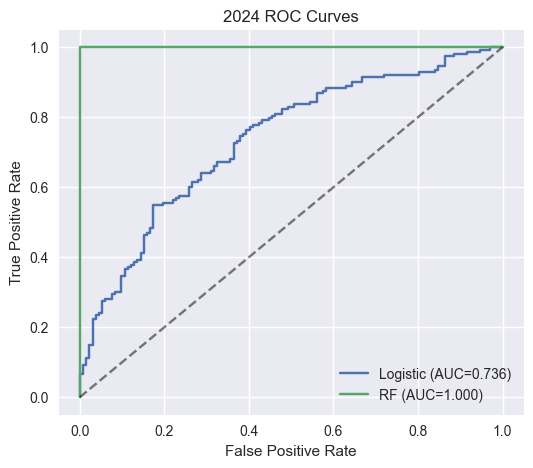

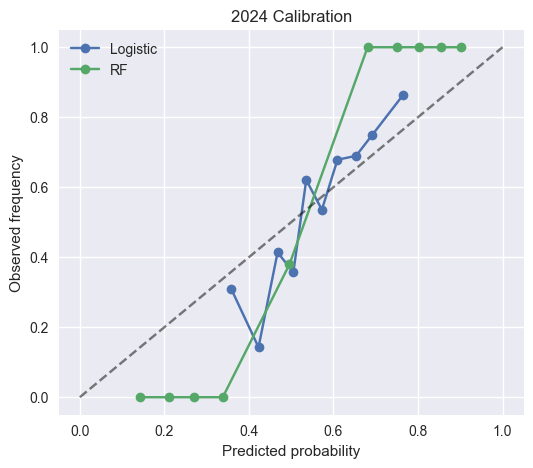

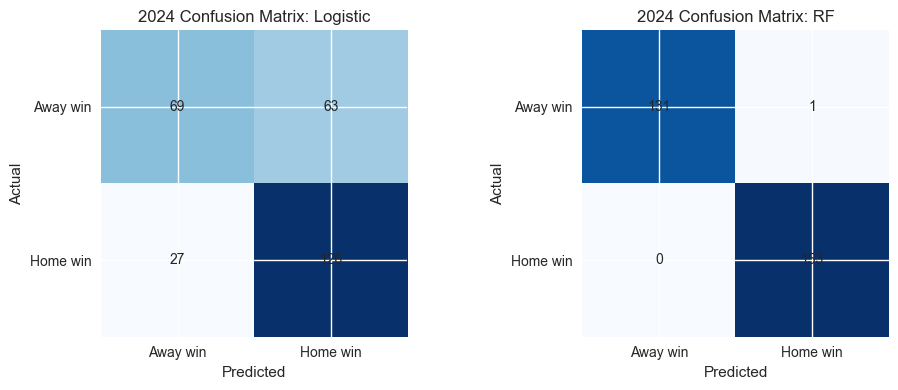

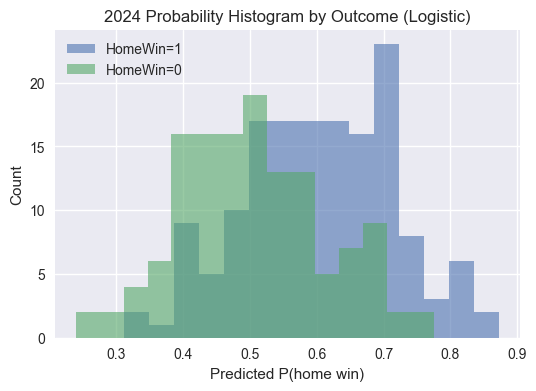

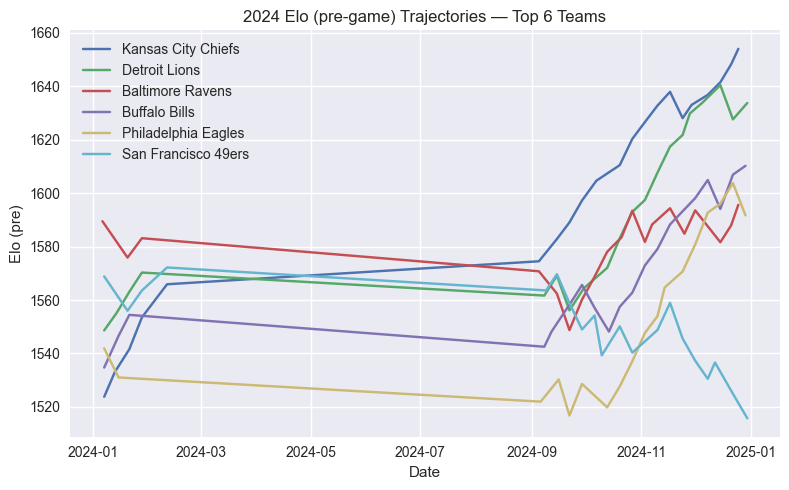

In [ ]:
# Here are some visualizations for the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve

plt.style.use('seaborn-v0_8')

# Helper to align feature DataFrame columns to a fitted model
def align_X_to_model(df_features: pd.DataFrame, model) -> pd.DataFrame:
    names = None
    if hasattr(model, 'feature_names_in_'):
        names = list(model.feature_names_in_)
    if names is None and hasattr(model, 'named_steps'):
        for step in model.named_steps.values():
            if hasattr(step, 'feature_names_in_'):
                names = list(step.feature_names_in_)
                break
    if names is None:
        # fall back to given columns
        return df_features
    return pd.DataFrame({c: (df_features[c] if c in df_features.columns else 0.0) for c in names})

# Choose available models
models = []
if 'pipe' in globals():
    models.append(('Logistic', pipe))
if 'rf_all' in globals():
    models.append(('RF', rf_all))
elif 'rf' in globals():
    models.append(('RF', rf))

# 1) 2024 ROC and Calibration
mask_2024 = (feat_df['Season'] == 2024)
X24_any = feat_df.loc[mask_2024, feat_df.columns.difference(['HomeWin'])].fillna(0.0)
y24 = feat_df.loc[mask_2024, 'HomeWin']

probs_2024 = {}
for name, m in models:
    X_aligned = align_X_to_model(X24_any, m)
    probs_2024[name] = m.predict_proba(X_aligned)[:,1]

if probs_2024:
    # ROC
    plt.figure(figsize=(6,5))
    for name, p in probs_2024.items():
        fpr, tpr, _ = roc_curve(y24, p)
        auc = roc_auc_score(y24, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('2024 ROC Curves'); plt.legend()
    plt.show()

    # Calibration
    plt.figure(figsize=(6,5))
    for name, p in probs_2024.items():
        frac_pos, mean_pred = calibration_curve(y24, p, n_bins=10, strategy='quantile')
        plt.plot(mean_pred, frac_pos, marker='o', label=name)
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency'); plt.title('2024 Calibration'); plt.legend()
    plt.show()
else:
    print('No trained models found for 2024 ROC/Calibration.')

# 2) 2024 Confusion matrices for available models
if models:
    n = len(models)
    plt.figure(figsize=(5*n,4))
    for i, (name, m) in enumerate(models, start=1):
        X_aligned = align_X_to_model(X24_any, m)
        p = m.predict_proba(X_aligned)[:,1]
        pred = (p >= 0.5).astype(int)
        cm = confusion_matrix(y24, pred)
        ax = plt.subplot(1, n, i)
        im = ax.imshow(cm, cmap='Blues')
        for (r, c), val in np.ndenumerate(cm):
            ax.text(c, r, int(val), ha='center', va='center')
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        ax.set_xticklabels(['Away win','Home win'])
        ax.set_yticklabels(['Away win','Home win'])
        ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
        ax.set_title(f'2024 Confusion Matrix: {name}')
    plt.tight_layout(); plt.show()

# 3) 2024 probability histograms split by outcome (use Logistic if available else RF)
chosen = None
for cand in ['Logistic','RF']:
    if cand in probs_2024:
        chosen = cand; break
if chosen is not None:
    p = probs_2024[chosen]
    plt.figure(figsize=(6,4))
    plt.hist(p[y24==1], bins=15, alpha=0.6, label='HomeWin=1')
    plt.hist(p[y24==0], bins=15, alpha=0.6, label='HomeWin=0')
    plt.xlabel('Predicted P(home win)'); plt.ylabel('Count'); plt.title(f'2024 Probability Histogram by Outcome ({chosen})'); plt.legend(); plt.show()
else:
    print('No probabilities available for 2024 histogram.')

# 4) Elo trajectories for top teams in 2024 (based on mean pre-game Elo)
if {'home_elo_pre','away_elo_pre','Date','Home','Visitor','Season'}.issubset(set(feat_df.columns)):
    elo_home = feat_df.loc[mask_2024, ['Date','Home','home_elo_pre']].rename(columns={'Home':'Team','home_elo_pre':'elo_pre'})
    elo_away = feat_df.loc[mask_2024, ['Date','Visitor','away_elo_pre']].rename(columns={'Visitor':'Team','away_elo_pre':'elo_pre'})
    elo_long = pd.concat([elo_home, elo_away], ignore_index=True)
    elo_long = elo_long.dropna().sort_values(['Team','Date'])
    team_mean = elo_long.groupby('Team')['elo_pre'].mean().sort_values(ascending=False)
    top_teams = team_mean.head(6).index.tolist()
    plt.figure(figsize=(8,5))
    for team in top_teams:
        ts = elo_long[elo_long['Team']==team].sort_values('Date')
        plt.plot(ts['Date'], ts['elo_pre'], label=team)
    plt.title('2024 Elo (pre-game) Trajectories — Top 6 Teams'); plt.xlabel('Date'); plt.ylabel('Elo (pre)'); plt.legend(); plt.tight_layout(); plt.show()
else:
    print('Elo columns not available for trajectories.')


### How to read the visualizations

- 2024 ROC Curves:
  - Shows the tradeoff between true positive rate and false positive rate at all thresholds.
  - The AUC summarizes ranking quality; higher is better. AUC > 0.65 is solid; > 0.70 is strong.

- 2024 Calibration Curve:
  - Compares predicted probabilities to observed frequencies across bins.
  - A well-calibrated model tracks the diagonal. Points above diagonal mean under-confidence; below mean over-confidence.

- 2024 Confusion Matrix:
  - Counts of correct/incorrect predictions at the 0.5 threshold (rows = actual, columns = predicted).
  - Use alongside ROC/LogLoss; accuracy at one threshold can hide calibration issues.

- 2024 Probability Histograms by Outcome:
  - Distributions of predicted P(home win) for true wins vs losses.
  - Better separation (less overlap) indicates more confident discrimination.

- 2024 Elo Trajectories (Top Teams):
  - Pre-game Elo evolution over the season for the highest-rated teams.
  - Helps contextualize why certain matchups had higher/lower predicted probabilities.
